<a href="https://www.kaggle.com/code/kangnurrohman/polarity-determination-with-lstm?scriptVersionId=113336517" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Install Library

In [1]:
!pip install Sastrawi

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')
warnings.filterwarnings("ignore", category=DeprecationWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.0 MB/s eta 0:00:00


## Load Library

In [2]:
import re
import tqdm
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import load_model
from nltk.tokenize import word_tokenize
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

## Load Data

In [3]:
df = pd.read_excel('/kaggle/input/review-of-the-application-pln-mobile/review of the application PLN mobile.xlsx')
df.rename(columns = {'content':'review', 'score':'sentiment'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201042 entries, 0 to 201041
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              201042 non-null  object        
 1   userName              201042 non-null  object        
 2   userImage             201042 non-null  object        
 3   review                201042 non-null  object        
 4   sentiment             201042 non-null  int64         
 5   thumbsUpCount         201042 non-null  int64         
 6   reviewCreatedVersion  174363 non-null  object        
 7   at                    201042 non-null  datetime64[ns]
 8   replyContent          195639 non-null  object        
 9   repliedAt             195639 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 15.3+ MB


In [4]:
df = df.sort_values(by='at', ascending=False)
df = df[['review', 'sentiment']]
df.head()

,review,sentiment
0,Sangat bermanfaat👍👍,5
1,PLN terbaik,5
2,😀,5
3,Mudah dan simpel untuk menikmati pelayanan PLN...,5
4,Baik,5


## Exploratory Data Analysis

In [5]:
df = df.replace({'sentiment' : {1:'negative', 2:'negative', 3:'neutral', 4:'positive', 5: 'positive' }})
df.head()

,review,sentiment
0,Sangat bermanfaat👍👍,positive
1,PLN terbaik,positive
2,😀,positive
3,Mudah dan simpel untuk menikmati pelayanan PLN...,positive
4,Baik,positive


In [6]:
df.sentiment.value_counts()

positive    175750
negative     19925
neutral       5367
Name: sentiment, dtype: int64

In [7]:
#removing neutral
df = df[df.sentiment != "neutral"]

## Data Preprocessing

In [8]:
def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

def remove_number(text):
    return  re.sub(r"\d+", "", text)

def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

def remove_whitespace_LT(text):
    return text.strip()

def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def word_tokenize_wrapper(text):
    return word_tokenize(text)

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('indonesian')
    #list_stopwords = stopwords.words('indonesian')
    #list_stopwords.extend([])
    #txt_stopword = pd.read_csv("#", names= ["stopwords"], header = None)
    #list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
    return [word for word in words if word not in list_stopwords]

def stemmed_wrapper(term):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(term)

In [9]:
def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    #case folding
    doc = doc.lower()
    doc = doc.lower()
    #tokenization
    doc = remove_tweet_special(doc)
    doc = remove_number(doc)
    doc = remove_punctuation(doc)
    doc = remove_whitespace_LT(doc)
    doc = remove_whitespace_multiple(doc)
    doc = remove_singl_char(doc)
    doc = word_tokenize_wrapper(doc)
    #filtering
    doc = stopwords_removal(doc)
    #Stemming for indonesian
    #doc = stemmed_wrapper(doc)
    norm_docs.append(doc)
    
  norm_docs = [" ".join(word) for word in norm_docs]
  return norm_docs

In [10]:
%%time
df.review = pre_process_corpus(df.review)

100%|██████████| 195675/195675 [01:50<00:00, 1773.50it/s]


CPU times: user 1min 44s, sys: 4.64 s, total: 1min 49s
Wall time: 1min 50s


In [11]:
df.head()

,review,sentiment
0,bermanfaat,positive
1,pln terbaik,positive
2,,positive
3,mudah simpel menikmati pelayanan pln fitur keb...,positive
4,,positive


## Handling imbalance (Oversampling)

In [12]:
from sklearn.utils import resample
# Separate majority and minority classes in training data for upsampling 
data_majority = df[df['sentiment'] == 'positive']
data_minority = df[df['sentiment'] == 'negative']

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_balance = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
print("After upsampling\n",df_balance.sentiment.value_counts(),sep = "")

majority class before upsample: (175750, 2)
minority class before upsample: (19925, 2)
After upsampling
positive    175750
negative    175750
Name: sentiment, dtype: int64


## Splitting Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_balance.review, df_balance.sentiment, test_size=0.2, random_state=42)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((281200,), (70300,), (281200,), (70300,))

## Data formatting

In [14]:
import keras

t = keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [15]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('pengamanan', 44226), ('<PAD>', 0), 1)

### Sequence

In [16]:
X_train  = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)

In [17]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=44227
Number of Documents=281200


### Sequence Normalization

In [18]:
MAX_SEQUENCE_LENGTH = 100

In [19]:
# pad dataset to a maximum review length in words
import tensorflow as tf
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((281200, 100), (70300, 100))

### Encoding Labels

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [21]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [22]:
VOCAB_SIZE = len(t.word_index)

## Build Model Architecture

In [23]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

inp = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp)
x = keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=True)(x)
#x = (keras.layers.LSTM(LSTM_DIM, return_sequences=True)(x)
x = keras.layers.Dense(LSTM_DIM, activation='relu')(x)
x = keras.layers.Dropout(rate=0.5)(x)
x = keras.layers.Dense(LSTM_DIM, activation='relu')(x)
x = keras.layers.Dropout(rate=0.5)(x)

outp = keras.layers.Dense(1, activation='sigmoid')(x)
# initialize the model
model = keras.models.Model(inputs=inp, outputs=outp)

# make the model parallel
#model2 = tf.keras.utils.multi_gpu_model(model, gpus=2)
    
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
model.summary()

2022-12-09 04:04:52.034171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 04:04:52.035117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 04:04:52.341711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 04:04:52.342568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 04:04:52.343384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          13268100  
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 100, 128)          220160    
_________________________________________________________________
dense (Dense)                (None, 100, 128)          16512     
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 100, 128)          16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0     

## Train Model

In [24]:
batch_size = 128
epochs = 300
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint('./best_model/best_model_lstm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
history = model.fit(X_train, y_train,  batch_size=batch_size, shuffle=True, validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

2022-12-09 04:04:58.198748: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-12-09 04:05:01.120902: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1978/1978 [==============================] - 47s 21ms/step - loss: 0.6601 - accuracy: 0.5464 - val_loss: 0.6557 - val_accuracy: 0.5490

Epoch 00001: val_accuracy improved from -inf to 0.54896, saving model to ./best_model/best_model_lstm.h5
Epoch 2/300
1978/1978 [==============================] - 41s 21ms/step - loss: 0.6539 - accuracy: 0.5492 - val_loss: 0.6546 - val_accuracy: 0.5495

Epoch 00002: val_accuracy improved from 0.54896 to 0.54945, saving model to ./best_model/best_model_lstm.h5
Epoch 3/300
1978/1978 [==============================] - 43s 22ms/step - loss: 0.6518 - accuracy: 0.5500 - val_loss: 0.6543 - val_accuracy: 0.5496

Epoch 00003: val_accuracy improved from 0.54945 to 0.54961, saving model to ./best_model/best_model_lstm.h5
Epoch 4/300
1978/1978 [==============================] - 43s 22ms/step - loss: 0.6508 - accuracy: 0.5503 - val_loss: 0.6572 - val_accuracy: 0.5496

Epoch 00004: val_accuracy improved from 0.54961 to 0.54964, saving model to ./best_model/best_model

## Evaluate Model Performance

In [25]:
saved_model = load_model('./best_model/best_model_lstm.h5')
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

2197/2197 [==============================] - 15s 7ms/step - loss: 0.6560 - accuracy: 0.5512
Train: 55.18%, Test: 55.12%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


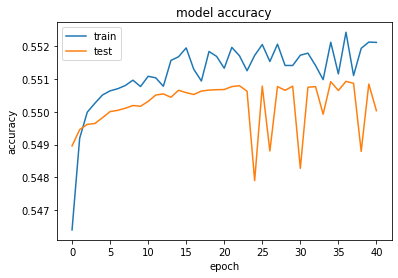

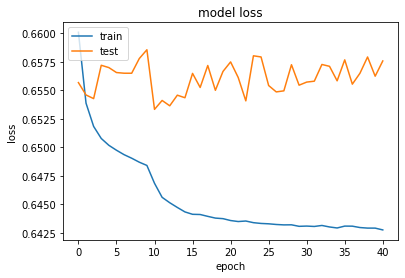

In [26]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]

2197/2197 [==============================] - 12s 5ms/step
